<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">


# London Transport Network
--- 

This dataset obtained from [Manlio De Domenico's webpage](https://comunelab.fbk.eu/data.php) (direct file link: [London Multiplex Transport](https://comunelab.fbk.eu/data/London_Multiplex_Transport.zip), put the unzipped folder into the same folder as this notebook) contains data about the London Transport Network of tube, overground and DLR connecting 369 stations.  Additionally, it contains data about disruptions in the network collected from Twitter. A detailed description of the dataset by the authors is included. 

The files contain the following information:

1. *london_transport_raw.edges*: the individual lines and the stations they connect

2. *london_transport_nodes.txt*: the stations, their ID, and their coordinates

3. *london_transport_multiplex.edges*: the first column indicates if the connection is through tube (1), overground (2) or DLR (3). The second and third column indicate the corresponding link through the station IDs. The fourth column indicates how many different lines run between these two nodes (that is only relevant for the tube).

4. london_transport_disruptions_summary.txt: summary statistics about the recorded disruptions for the individual lines and links.

5. A folder with the disruptions that occured giving each time the network with the links existing during the disruption.

The dataset actually consists of three networks, one for the tube, one for the overground and one for the DLR, all connecting the same nodes. One can consider these networks separately or, as passengers can use all three of them, the combined network. In that case one speaks of a multiplex network.

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import networkx as nx
plt.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

warnings.simplefilter('ignore')

In [2]:
df_raw = pd.read_csv(
    '../London_Multiplex_Transport/Dataset/london_transport_raw.edges', sep=' ', header=None)
df_raw.columns = ['line', 'station_1', 'station_2']
print(df_raw.shape)
df_raw.head()

(503, 3)


,line,station_1,station_2
0,bakerloo,harrow&wealdstone,kenton
1,bakerloo,kenton,southkenton
2,bakerloo,southkenton,northwembley
3,bakerloo,northwembley,wembleycentral
4,bakerloo,wembleycentral,stonebridgepark


In [3]:
df_raw.line.unique()

array(['bakerloo', 'central', 'circle', 'district', 'hammersmith&city',
       'jubilee', 'metropolitan', 'northern', 'piccadilly', 'victoria',
       'waterloo&city', 'overground', 'dlr'], dtype=object)

In [4]:
df_nodes = pd.read_csv(
    '../London_Multiplex_Transport/Dataset/london_transport_nodes.txt', sep=' ')
print(df_nodes.shape)
df_nodes.head()

(369, 4)


,nodeID,nodeLabel,nodeLat,nodeLong
0,0,abbeyroad,51.531952,0.003738
1,1,westham,51.528526,0.005332
2,2,actoncentral,51.508758,-0.263416
3,3,willesdenjunction,51.532234,-0.243895
4,4,actontown,51.503071,-0.280288


In [5]:
df_multiplex = pd.read_csv(
    '../London_Multiplex_Transport/Dataset/london_transport_multiplex.edges', sep=' ', header=None)
df_multiplex.columns = ['layer', 'node_1', 'node_2', 'weight']
print(df_multiplex.shape)
df_multiplex.head()

(441, 4)


,layer,node_1,node_2,weight
0,1,1,77,2
1,1,1,106,1
2,1,1,219,1
3,1,1,321,2
4,1,3,224,1


In [6]:
len(set(df_multiplex[df_multiplex.layer == 1]
        [['node_1', 'node_2']].values.flatten()))

271

In [7]:
df_disruption_sum = pd.read_csv(
    '../London_Multiplex_Transport/Dataset/london_transport_disruptions_summary.txt', sep=' ')
print(df_disruption_sum.shape)
df_disruption_sum.head()

(325, 6)


,#DISRUP_ID,LAYER,STATION_A,STATION_B,FREQUENCY%,DAMAGED_NODES%
0,DISR1,metropolitan,aldgate,bakerstreet,3.3457,2.439
1,DISR2,hammersmith&city,barking,moorgate,2.8914,3.523
2,DISR3,dlr,beckton,canningtown,2.5609,2.439
3,DISR4,overground,claphamjunction,surreyquays,2.0240,1.897
4,DISR5,overground,richmond,willesdenjunction,1.9413,1.626


In [8]:
df_layers = pd.read_csv(
    '../London_Multiplex_Transport/Dataset/london_transport_layers.txt', sep='\t')
df_layers['layerID'] = [int(x[0]) for x in list(df_layers.iloc[:, 0])]
df_layers['layerLabel'] = [x[2:] for x in list(df_layers.iloc[:, 0])]
df_layers.drop(df_layers.columns[0], axis=1, inplace=True)
df_layers.head()

,layerID,layerLabel
0,1,Tube (All underground lines aggregated)
1,2,Overground
2,3,DLR


In [9]:
df_multiplex[df_multiplex.layer == 1].loc[:, 'node_1':].head()

,node_1,node_2,weight
0,1,77,2
1,1,106,1
2,1,219,1
3,1,321,2
4,3,224,1


In [10]:
df_multiplex[df_multiplex.layer == 1].describe()

,layer,node_1,node_2,weight
count,312.0,312.000000,312.000000,312.000000
mean,1.0,130.804487,209.314103,1.198718
std,0.0,97.611328,103.419652,0.459552
min,1.0,1.000000,5.000000,1.000000
25%,1.0,44.000000,127.000000,1.000000
50%,1.0,116.000000,219.000000,1.000000
75%,1.0,205.250000,299.000000,1.000000
max,1.0,367.000000,368.000000,3.000000


## Construct the graphs:

* Which graphs would you like to construct?
* Which variables would you take as nodes and edges?
* Select the corresponding data from the above dataframes and transform to matrix format using `as_matrix()`.
* Construct empty graphs, then add the nodes and the edges. You can insert lists of nodes and edges using the networkx functions `add_nodes_from` and `add_edges_from`.
* For each graph that you construct, indicate the number of nodes and edges.

In [11]:
data_1 = df_multiplex[df_multiplex.layer == 1].loc[:, 'node_1':].as_matrix()
data_2 = df_multiplex[df_multiplex.layer == 2].loc[:, 'node_1':].as_matrix()
data_3 = df_multiplex[df_multiplex.layer == 3].loc[:, 'node_1':].as_matrix()

G_tube = nx.Graph()
G_tube.add_nodes_from(list(range(0, 369)))
G_tube.add_weighted_edges_from(data_1)

G_overground = nx.Graph()
G_overground.add_nodes_from(list(range(0, 369)))
G_overground.add_weighted_edges_from(data_2)

G_DLR = nx.Graph()
G_DLR.add_nodes_from(list(range(0, 369)))
G_DLR.add_weighted_edges_from(data_3)

G_TO = nx.Graph()
G_TO.add_nodes_from(list(range(0, 369)))
G_TO.add_weighted_edges_from(data_1)
G_TO.add_weighted_edges_from(data_2)

G_TD = nx.Graph()
G_TD.add_nodes_from(list(range(0, 369)))
G_TD.add_weighted_edges_from(data_1)
G_TD.add_weighted_edges_from(data_3)

G_OD = nx.Graph()
G_OD.add_nodes_from(list(range(0, 369)))
G_OD.add_weighted_edges_from(data_2)
G_OD.add_weighted_edges_from(data_3)

G_all = nx.Graph()
G_all.add_nodes_from(list(range(0, 369)))
G_all.add_weighted_edges_from(data_1)
G_all.add_weighted_edges_from(data_2)
G_all.add_weighted_edges_from(data_3)

In [12]:
graph_dict = dict(list(zip(['G_tube', 'G_overground', 'G_DLR', 'G_TO', 'G_TD', 'G_OD', 'G_all'],
                           [G_tube, G_overground, G_DLR, G_TO, G_TD, G_OD, G_all])))
for key in graph_dict:
    print(key)
    print(nx.info(graph_dict[key]))
    print()

G_tube
Name: 
Type: Graph
Number of nodes: 369
Number of edges: 312
Average degree:   1.6911

G_overground
Name: 
Type: Graph
Number of nodes: 369
Number of edges: 83
Average degree:   0.4499

G_DLR
Name: 
Type: Graph
Number of nodes: 369
Number of edges: 46
Average degree:   0.2493

G_TO
Name: 
Type: Graph
Number of nodes: 369
Number of edges: 384
Average degree:   2.0813

G_TD
Name: 
Type: Graph
Number of nodes: 369
Number of edges: 358
Average degree:   1.9404

G_OD
Name: 
Type: Graph
Number of nodes: 369
Number of edges: 129
Average degree:   0.6992

G_all
Name: 
Type: Graph
Number of nodes: 369
Number of edges: 430
Average degree:   2.3306



## Plot the networks that you constructed

* Add the edges from all graphs to your plot.
* Color the edges according to if they belong to the tube, the overground or the DLR.
* Use the option `pos` in the drawing function to position the nodes according to their longitudinal and latitudinal coordinates. You have to provide a dictionary with node IDs as keys and coordinates as values.

In [13]:
color_labels_tube = [list(edge[2].values())[0] for edge in G_tube.edges(data=True)]
color_labels_DLR = [list(edge[2].values())[0] for edge in G_DLR.edges(data=True)]
color_labels_overground = [list(edge[2].values())[0] for edge in G_overground.edges(data=True)]

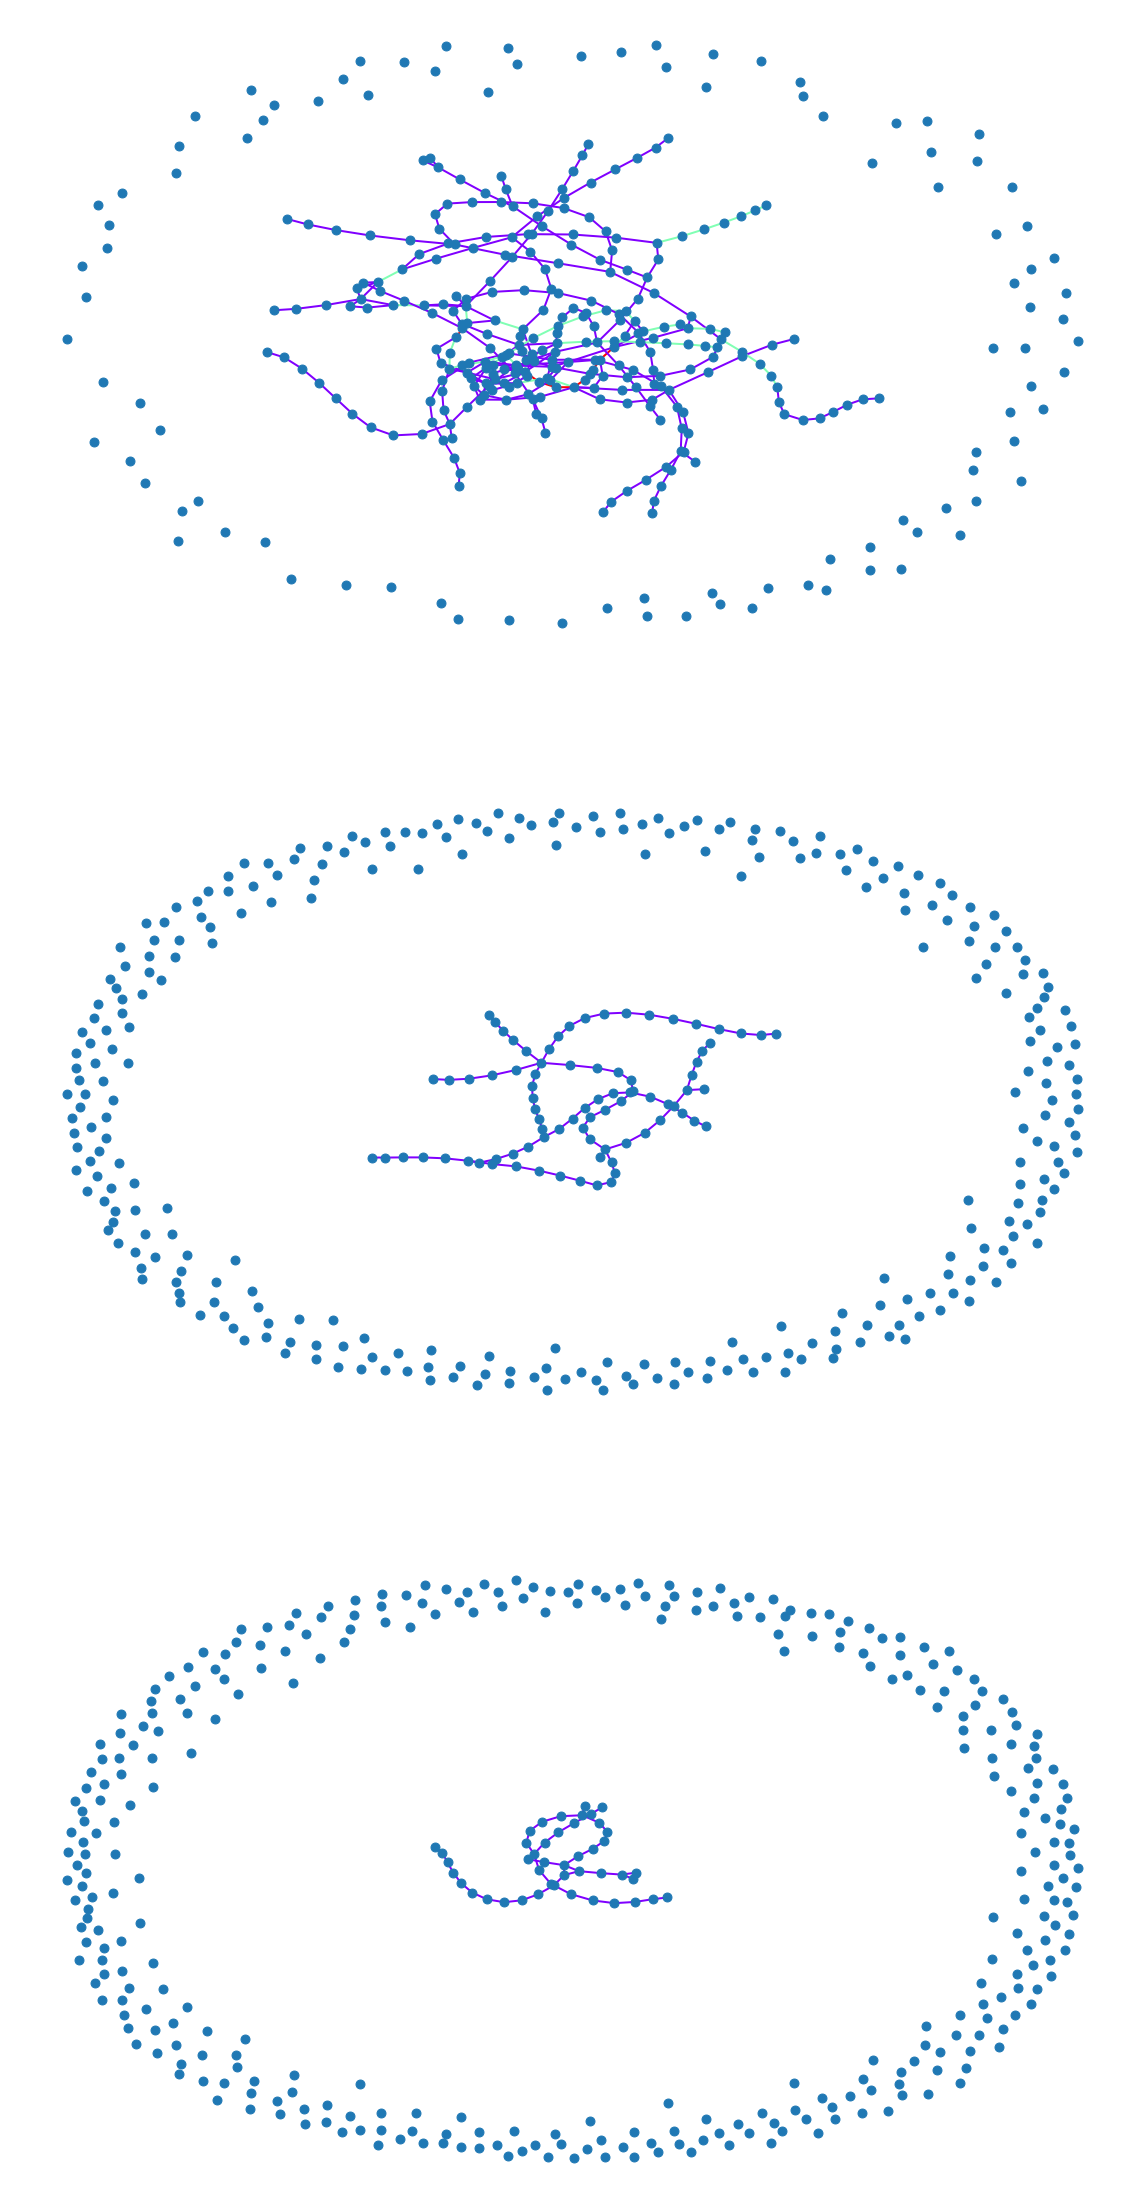

In [14]:
fig, ax = plt.subplots(nrows=3, figsize=(10, 20))
nx.draw(G_tube, node_size=20, edge_color=color_labels_tube, edge_cmap=cm.get_cmap('rainbow'), ax=ax[0])
nx.draw(G_overground, node_size=20, edge_color=color_labels_overground, edge_cmap=cm.get_cmap('rainbow'), ax=ax[1])
nx.draw(G_DLR, node_size=20, edge_color=color_labels_DLR, edge_cmap=cm.get_cmap('rainbow'), ax=ax[2])

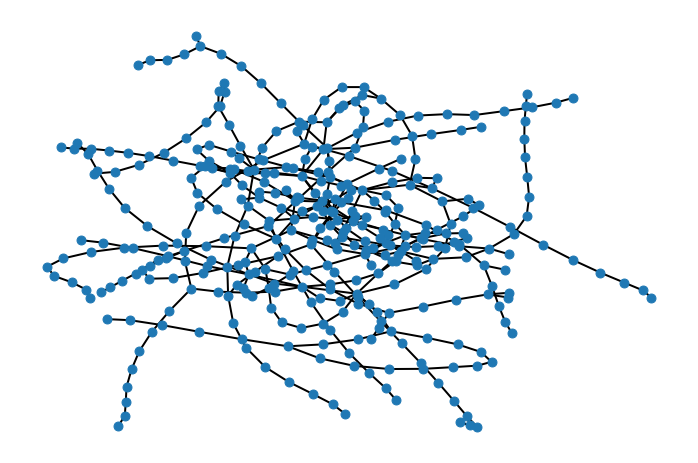

In [15]:
fig, ax = plt.subplots()
nx.draw(G_all, node_size=20, ax=ax)
plt.show()

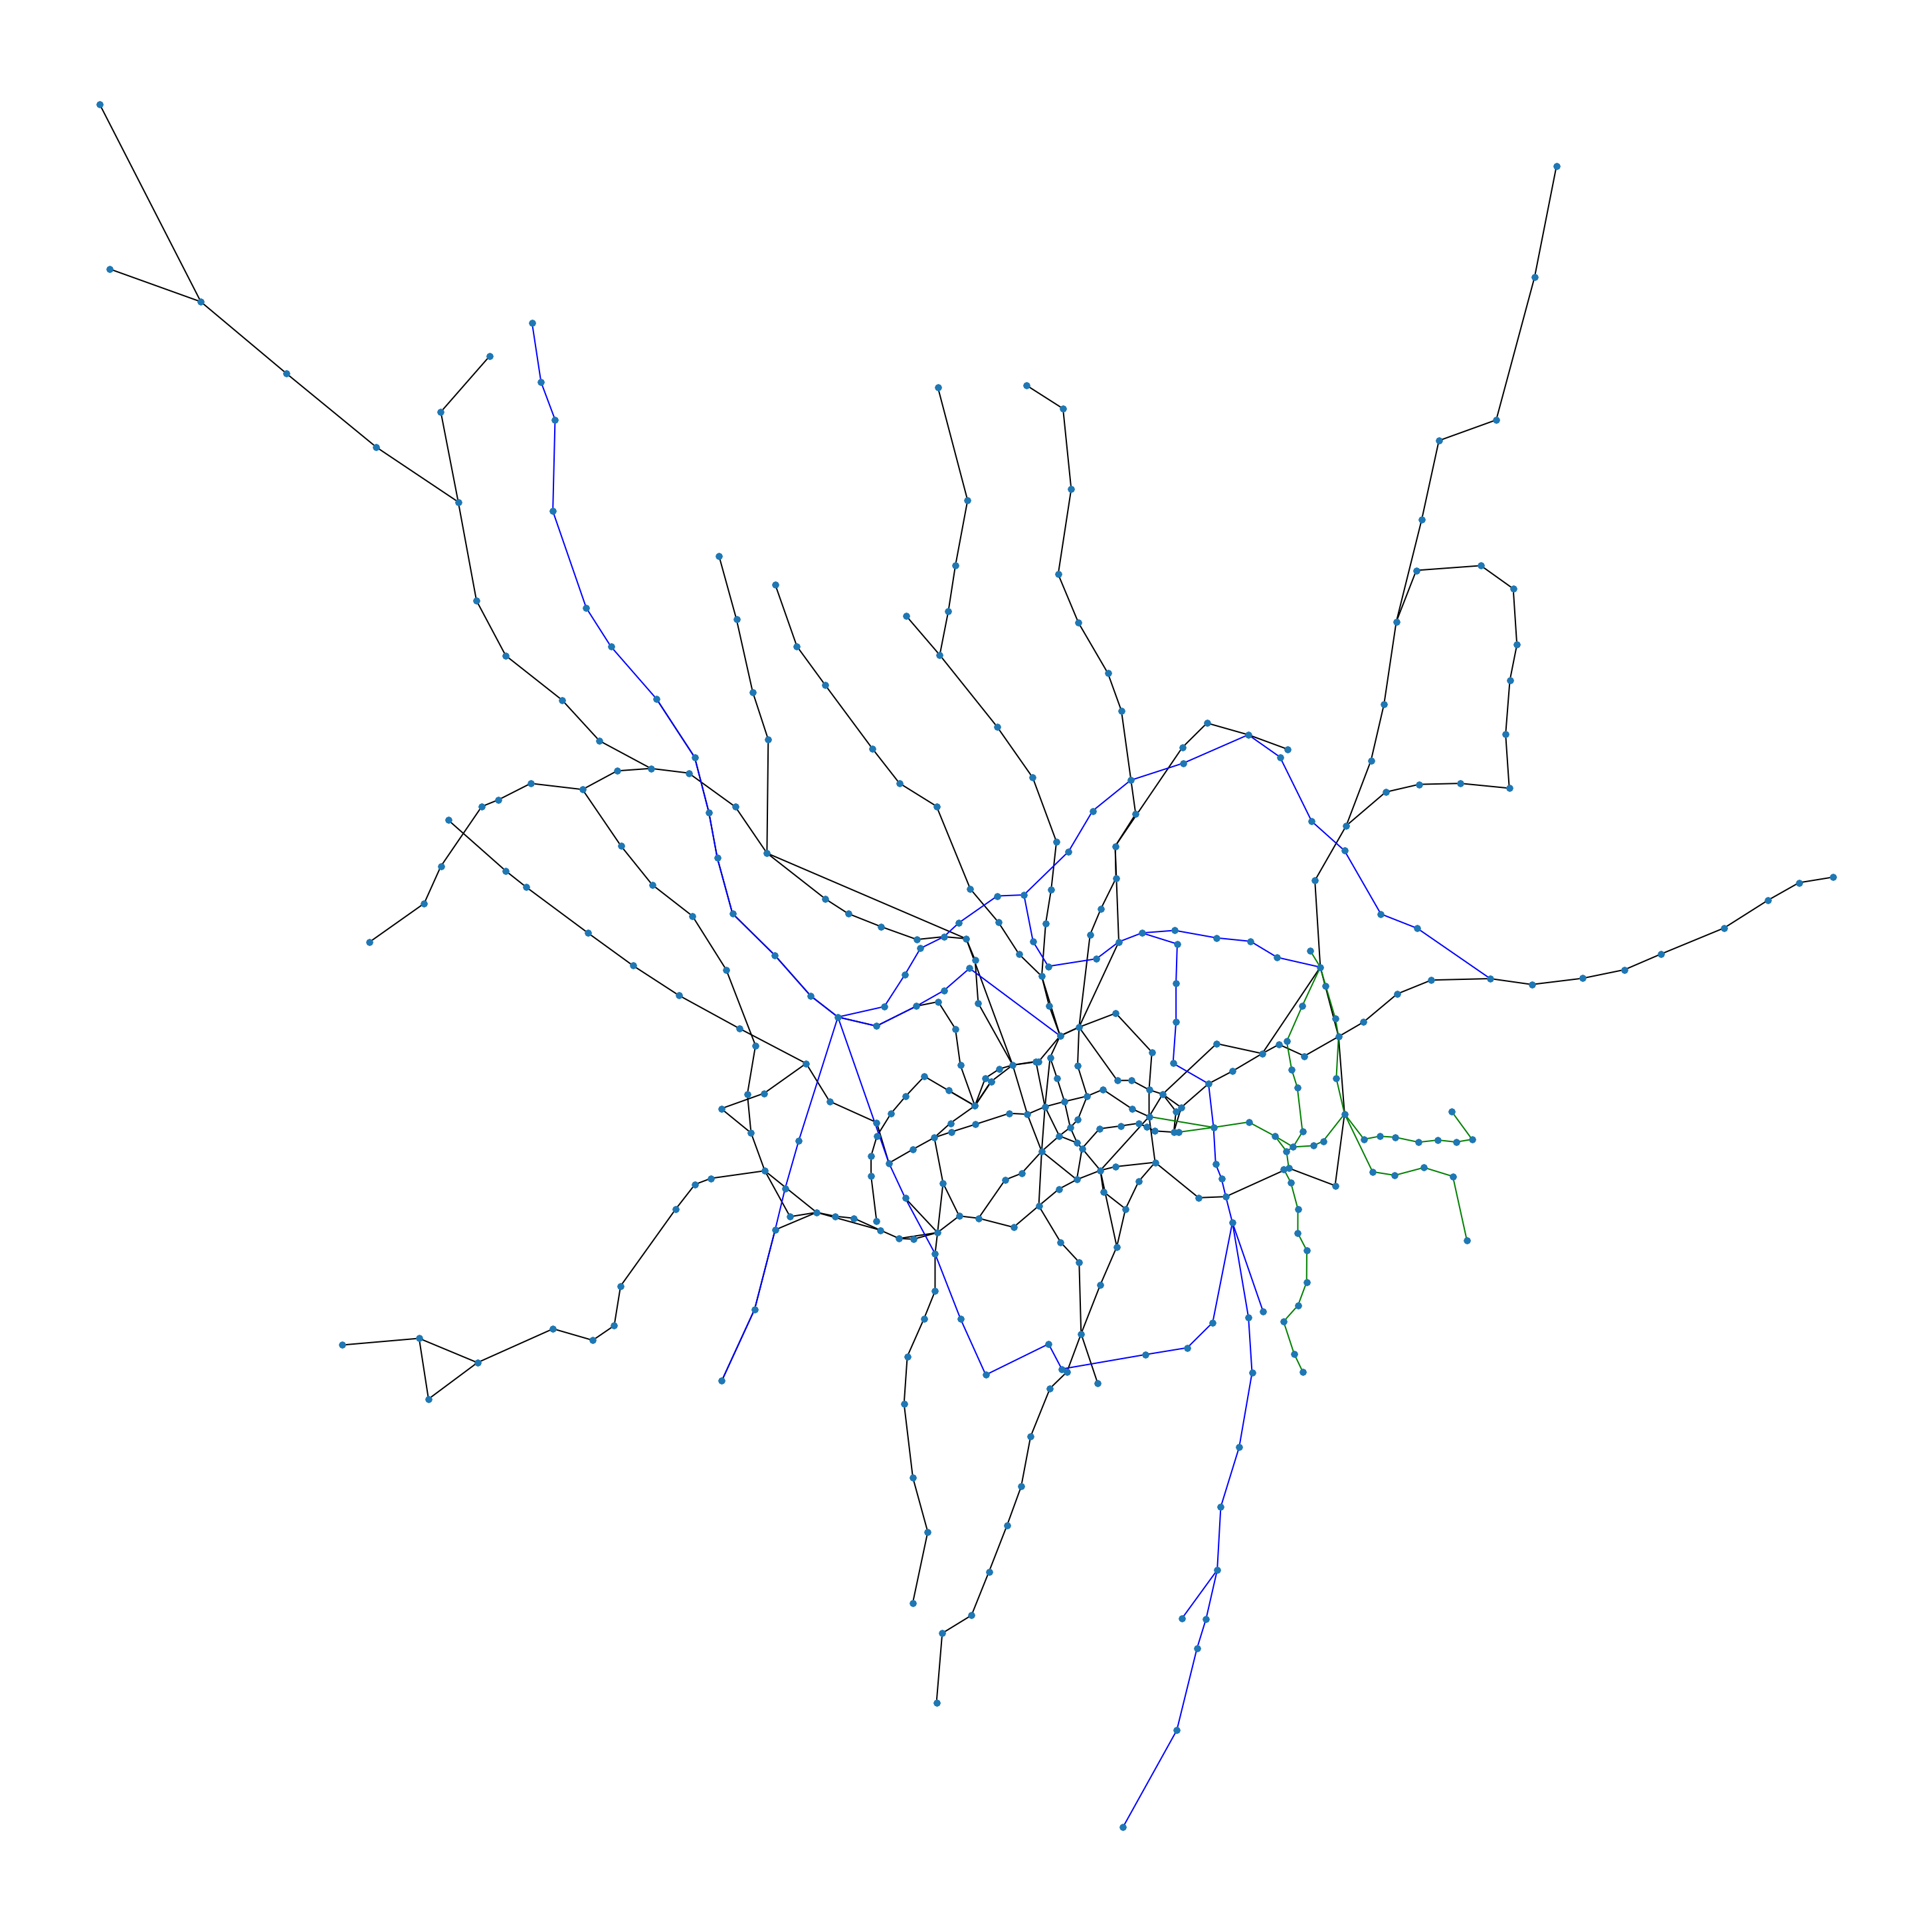

In [16]:
pos_dict = {}
for key in df_nodes.nodeID:
    # list(df_nodes.iloc[key,2:])
    pos_dict[key] = list(df_nodes.loc[key, ['nodeLong', 'nodeLat']].values)

plt.figure(figsize=(20, 20))
nx.draw(G_tube, pos=pos_dict, node_size=20)
nx.draw(G_overground, pos=pos_dict, node_size=20, edge_color='blue')
nx.draw(G_DLR, pos=pos_dict, node_size=20, edge_color='green')
plt.show()

## What is the diameter of your networks?

* The diameter is the longest of all shortest paths between any two points.
* Take the largest connected component for that. You can obtain the connected subgraphs with the networkx command `connected_component_subgraphs`.
* You can obtain the diameter of a connected component with the networkx command `diameter`.

In [17]:
G_tube_connected = [G for G in nx.connected_component_subgraphs(
    G_tube) if G.number_of_nodes() > 1][0]
G_overground_connected = [G for G in nx.connected_component_subgraphs(
    G_overground) if G.number_of_nodes() > 1][0]
G_DLR_connected = [G for G in nx.connected_component_subgraphs(
    G_DLR) if G.number_of_nodes() > 1][0]
G_all_connected = [G for G in nx.connected_component_subgraphs(
    G_all) if G.number_of_nodes() > 1][0]

connected_graphs = [G_tube_connected,
                    G_overground_connected, G_DLR_connected, G_all_connected]

for G in connected_graphs:
    print(nx.diameter(G))

39
35
23
39


## Get the shortest path between any two stations

* Write a function which takes your network graph, the starting and the end station as arguments. It should return the length of the shortest path between them, the intermediate stations and which lines you have to take.
* Which is the shortest path for getting from Aldgate East to South Kensington? 
* Is that the connection you would choose? 
* What information would you like to add to your network to obtain a better recommendation? How would you add it? (Not required to do that explicitly now.)

Hint: Use the networkx commands `shortest_path` and `shortest_path_length`.

In [18]:
def your_shortest_path(G, start_station, end_station, df_nodes=df_nodes, df_raw=df_raw):
    nodecheck = 1
    try:
        start_node = int(df_nodes.nodeID[df_nodes.nodeLabel == start_station])
    except:
        print('Your start point does not exist.')
        nodecheck = 0
    try:
        end_node = int(df_nodes.nodeID[df_nodes.nodeLabel == end_station])
    except:
        print('Your start point does not exist.')
        nodecheck = 0
    if nodecheck == 1:
        try:
            pathlength = nx.shortest_path_length(G, start_node, end_node)
            path = nx.shortest_path(G, start_node, end_node)
            print("The shortest path from {} to {} crosses".format(
                start_station, end_station), end=' ')
            print((', ').join(list(df_nodes.nodeLabel[path])[1:-1])+".")
            print("The path length is", str(pathlength)+'.')
            print("You will have to take the following lines:")
            connection = list(
                df_nodes.nodeLabel[nx.shortest_path(G, start_node, end_node)])
            lines = []
            for i in range(len(connection)-1):
                conn = list(df_raw.line[((df_raw.station_1 == connection[i]) & (df_raw.station_2 == connection[i+1])) |
                                        ((df_raw.station_1 == connection[i+1]) & (df_raw.station_2 == connection[i]))])
                if len(conn) > 1:
                    conn = (' or ').join(conn)
                else:
                    conn = conn[0]
                if conn not in lines:
                    lines.append(conn)
            print((', ').join(lines))
        except:
            print("There is no path between {} and {}.".format(
                start_station, end_station))

In [19]:
your_shortest_path(G_all, 'mileend', 'bakerstreet')

The shortest path from mileend to bakerstreet crosses bethnalgreen, liverpoolstreet, bank, waterloo, westminster, greenpark, bondstreet.
The path length is 8.
You will have to take the following lines:
central, waterloo&city, jubilee


In [20]:
your_shortest_path(G_all, 'limehouse', 'actoncentral')

The shortest path from limehouse to actoncentral crosses shadwell, bank, moorgate, oldstreet, angel, kingscrossstpancras, euston, southhampstead, kilburnhighroad, queenspark, kensalgreen, willesdenjunction.
The path length is 13.
You will have to take the following lines:
dlr, northern, northern or victoria, overground, bakerloo or overground


## Plot the degree distributions of your graphs

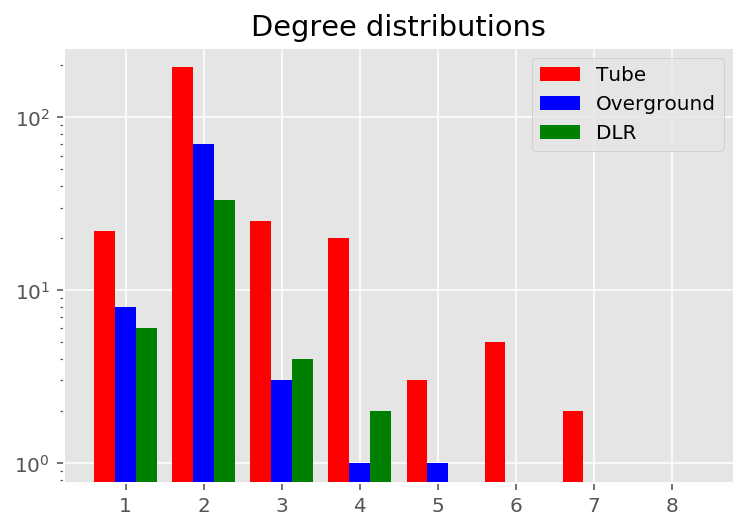

In [21]:
colors = ['red', 'blue', 'green']
plt.hist([list(dict(nx.degree(G_tube)).values()), list(dict(nx.degree(G_overground)).values()), list(dict(nx.degree(G_DLR)).values())],
         bins=np.linspace(0, 8, 9)+0.5, alpha=1, stacked=False, color=colors, label=colors)
plt.yscale('log')
plt.legend(['Tube', 'Overground', 'DLR'], prop={'size': 10})
plt.title('Degree distributions')
plt.show()

In [22]:
[x for x in list(nx.degree(G_tube)) if x[1] == 7]

[(27, 7), (181, 7)]

In [23]:
df_nodes[(df_nodes.nodeID == 27) | (df_nodes.nodeID == 181)]

,nodeID,nodeLabel,nodeLat,nodeLong
27,27,bakerstreet,51.523130,-0.156890
181,181,kingscrossstpancras,51.530312,-0.123858


## Obtain the betweenness for the nodes in the tube, overground and DLR networks

* Which are the 10 most important nodes  in each network?
* Are there correlations among these node rankings?

Hint: Use the networkx command `betweenness_centrality`.

In [24]:
list(graph_dict.items())
for item in list(graph_dict.items()):
    name = 'betweenness'+item[0][1:]
    df_nodes[name] = list(nx.betweenness_centrality(item[1]).values())

In [25]:
df_nodes['betweenness_tube'] = list(nx.betweenness_centrality(G_tube).values())
df_nodes['betweenness_overground'] = list(
    nx.betweenness_centrality(G_overground).values())
df_nodes['betweenness_DLR'] = list(nx.betweenness_centrality(G_DLR).values())

In [26]:
df_nodes.head()

,nodeID,nodeLabel,nodeLat,nodeLong,betweenness_tube,betweenness_overground,betweenness_DLR,betweenness_TO,betweenness_TD,betweenness_OD,betweenness_all
0,0,abbeyroad,51.531952,0.003738,0.000000,0.000000,0.001325,0.000000,0.000353,0.009028,0.000534
1,1,westham,51.528526,0.005332,0.049566,0.000000,0.001755,0.055626,0.097807,0.009014,0.113060
2,2,actoncentral,51.508758,-0.263416,0.000000,0.004620,0.000000,0.041633,0.000000,0.007167,0.042064
3,3,willesdenjunction,51.532234,-0.243895,0.027263,0.026744,0.000000,0.149481,0.031409,0.041849,0.158239
4,4,actontown,51.503071,-0.280288,0.061574,0.000000,0.000000,0.075709,0.070904,0.000000,0.084725


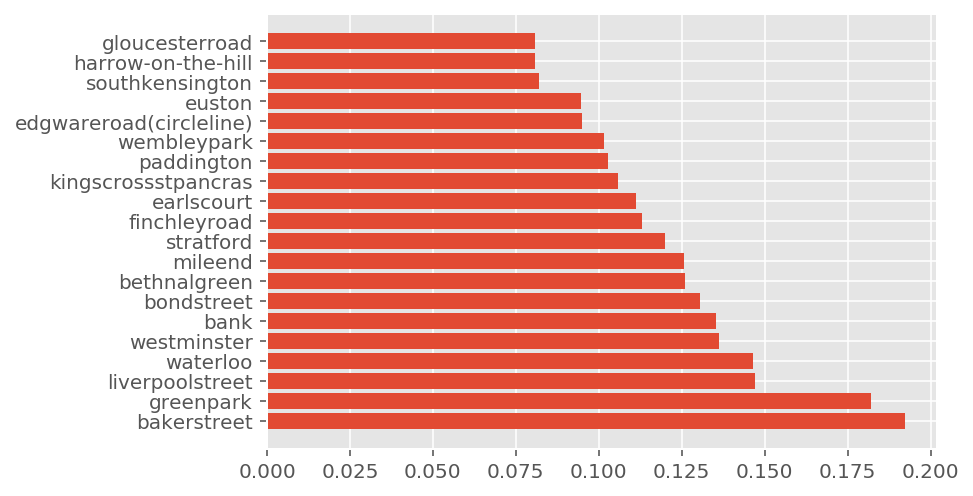

In [27]:
plt.barh(list(range(20)), df_nodes.sort_values(
    by='betweenness_tube', ascending=False).head(20).betweenness_tube)
plt.yticks(list(range(20)), df_nodes.sort_values(
    by='betweenness_tube', ascending=False).head(20).nodeLabel)
plt.show()

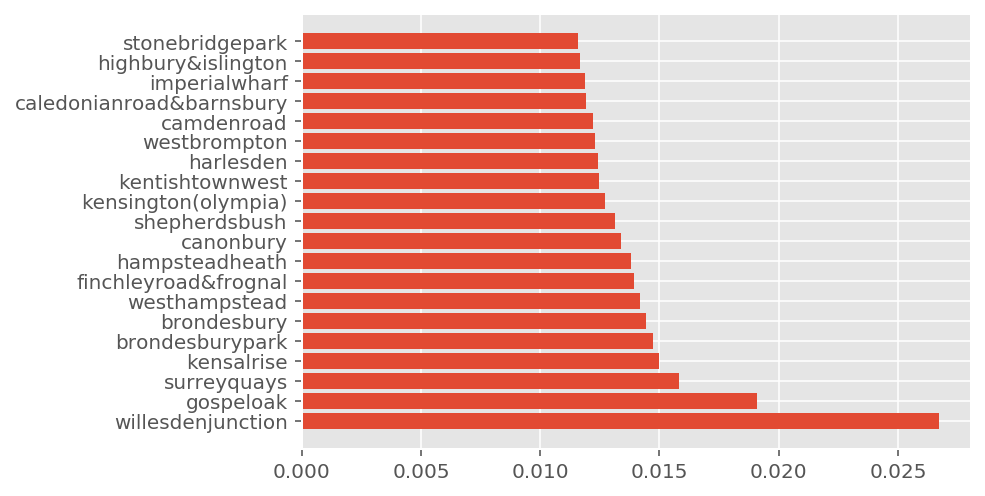

In [28]:
plt.barh(list(range(20)), df_nodes.sort_values(
    by='betweenness_overground', ascending=False).head(20).betweenness_overground)
plt.yticks(list(range(20)), df_nodes.sort_values(
    by='betweenness_overground', ascending=False).head(20).nodeLabel)
plt.show()

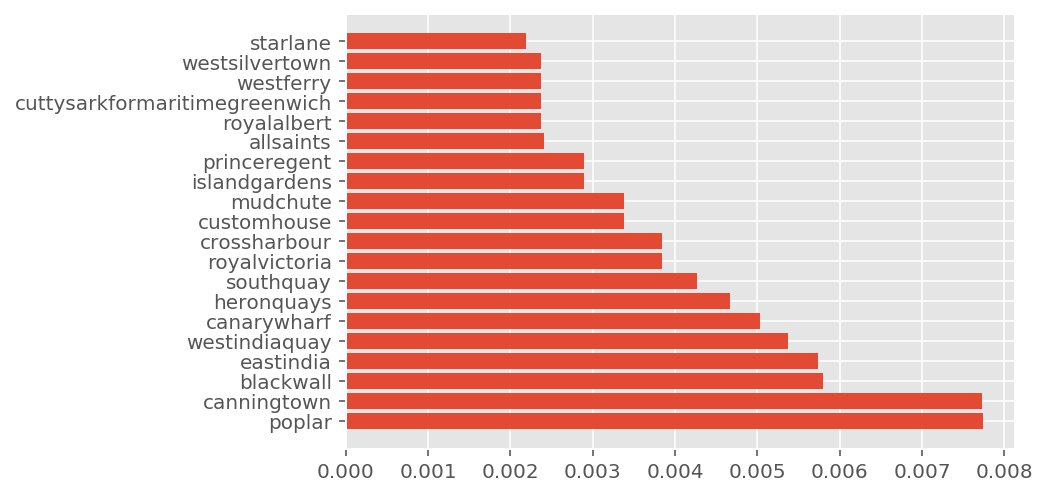

In [29]:
plt.barh(list(range(20)), df_nodes.sort_values(
    by='betweenness_DLR', ascending=False).head(20).betweenness_DLR)
plt.yticks(list(range(20)), df_nodes.sort_values(
    by='betweenness_DLR', ascending=False).head(20).nodeLabel)
plt.show()

In [30]:
df_nodes.head()

,nodeID,nodeLabel,nodeLat,nodeLong,betweenness_tube,betweenness_overground,betweenness_DLR,betweenness_TO,betweenness_TD,betweenness_OD,betweenness_all
0,0,abbeyroad,51.531952,0.003738,0.000000,0.000000,0.001325,0.000000,0.000353,0.009028,0.000534
1,1,westham,51.528526,0.005332,0.049566,0.000000,0.001755,0.055626,0.097807,0.009014,0.113060
2,2,actoncentral,51.508758,-0.263416,0.000000,0.004620,0.000000,0.041633,0.000000,0.007167,0.042064
3,3,willesdenjunction,51.532234,-0.243895,0.027263,0.026744,0.000000,0.149481,0.031409,0.041849,0.158239
4,4,actontown,51.503071,-0.280288,0.061574,0.000000,0.000000,0.075709,0.070904,0.000000,0.084725


In [31]:
df_nodes.loc[:, 'betweenness_overground':].corr()

,betweenness_overground,betweenness_DLR,betweenness_TO,betweenness_TD,betweenness_OD,betweenness_all
betweenness_overground,1.000000,-0.112198,0.158826,-0.189469,0.805735,0.140092
betweenness_DLR,-0.112198,1.000000,-0.180477,0.008441,0.320907,-0.002551
betweenness_TO,0.158826,-0.180477,1.000000,0.816932,0.051902,0.958940
betweenness_TD,-0.189469,0.008441,0.816932,1.000000,-0.144920,0.861707
betweenness_OD,0.805735,0.320907,0.051902,-0.144920,1.000000,0.146597
betweenness_all,0.140092,-0.002551,0.958940,0.861707,0.146597,1.000000


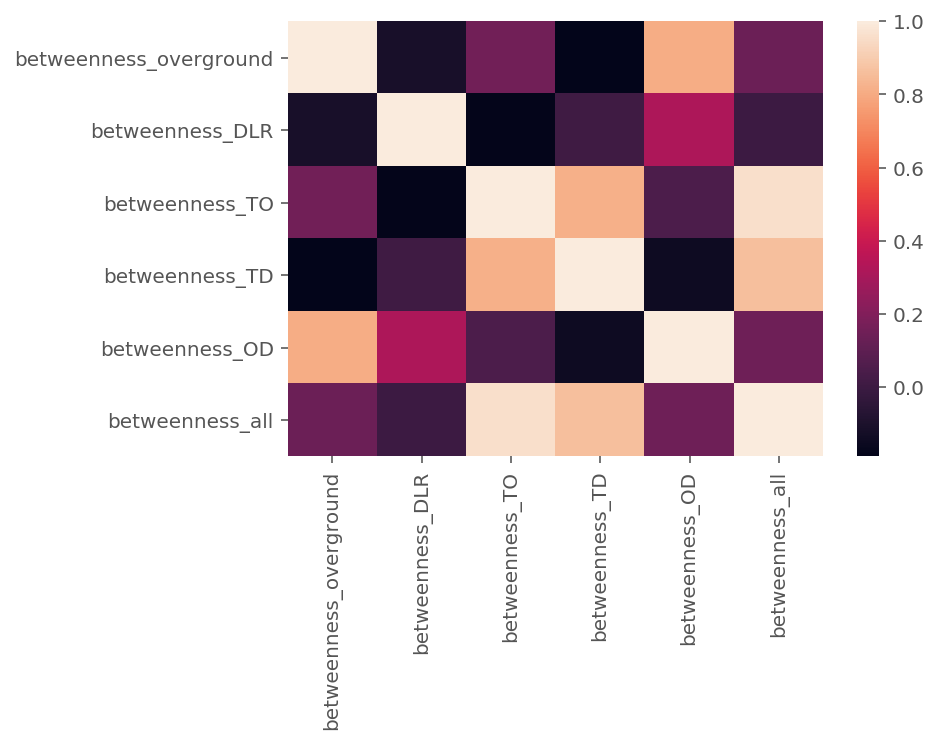

In [32]:
sns.heatmap(df_nodes.loc[:, 'betweenness_overground':].corr())
plt.show()

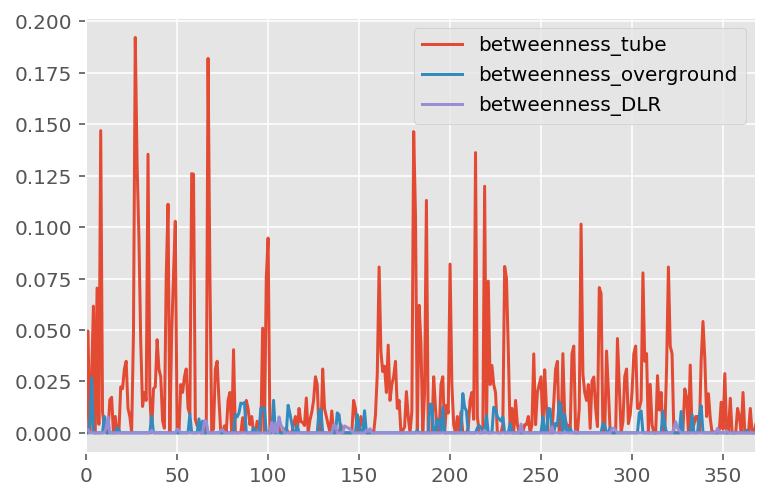

In [33]:
df_nodes[['betweenness_tube', 'betweenness_overground', 'betweenness_DLR']].plot()
plt.show()

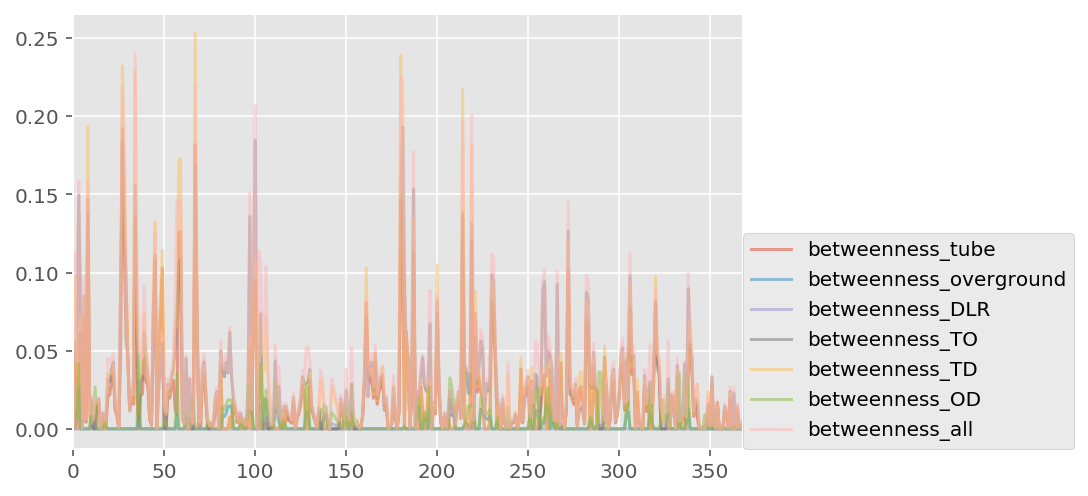

In [34]:
df_nodes[[col for col in df_nodes.columns if 'betweenness' in col]].plot(
    alpha=0.5)
plt.legend(loc=[1, 0])
plt.show()

## Optional (open ended):

Look at the disruption data. 
* How do the individual disruptions affect the connectivity, path length and betweenness of the network? Look first at just one of the disruptions.

In [35]:
list_disruptions = !ls ../London_Multiplex_Transport/Dataset/Disruptions/
len(list_disruptions)

325

In [36]:
df_disruptions_1 = pd.read_table(
    '../London_Multiplex_Transport/Dataset/Disruptions/'+list_disruptions[1], sep=' ', header=None)
df_disruptions_1.columns = ['layer', 'node_1', 'node_2', 'weight']
df_disruptions_1.head()

,layer,node_1,node_2,weight
0,1,1,106,1
1,1,1,219,1
2,1,1,321,2
3,1,1,77,2
4,1,3,224,1


In [37]:
dr_1_1 = df_disruptions_1[df_disruptions_1.layer ==
                          1].loc[:, 'node_1':].as_matrix()
dr_1_2 = df_disruptions_1[df_disruptions_1.layer ==
                          2].loc[:, 'node_1':].as_matrix()
dr_1_3 = df_disruptions_1[df_disruptions_1.layer ==
                          3].loc[:, 'node_1':].as_matrix()

G_dr_1_o = nx.Graph()
G_dr_1_o.add_nodes_from(list(range(0, 369)))
G_dr_1_o.add_weighted_edges_from(dr_1_2)

In [38]:
print(nx.info(G_overground))
print(nx.info(G_dr_1_o))

Name: 
Type: Graph
Number of nodes: 369
Number of edges: 83
Average degree:   0.4499
Name: 
Type: Graph
Number of nodes: 369
Number of edges: 70
Average degree:   0.3794


In [39]:
G_dr_1_o_conn = [G for G in nx.connected_component_subgraphs(
    G_dr_1_o) if G.number_of_nodes() > 1][0]

In [40]:
print(nx.info(G_overground_connected))
print(nx.info(G_dr_1_o_conn))

Name: 
Type: Graph
Number of nodes: 83
Number of edges: 83
Average degree:   2.0000
Name: 
Type: Graph
Number of nodes: 71
Number of edges: 70
Average degree:   1.9718


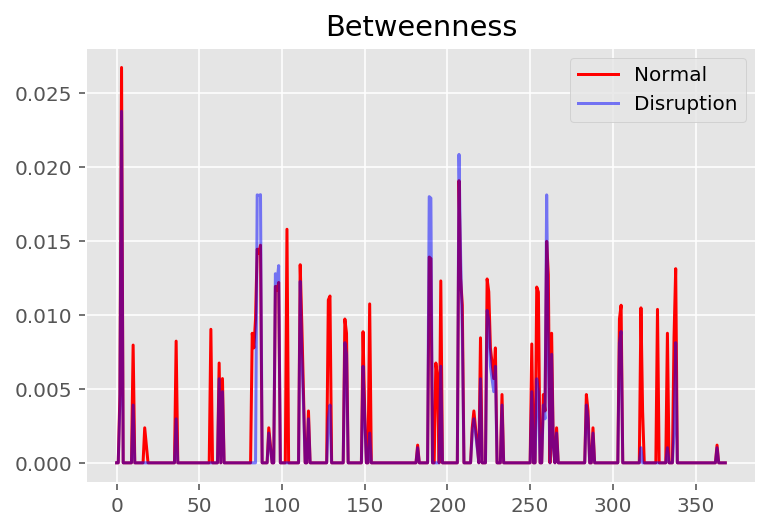

In [41]:
plt.plot(list(range(nx.number_of_nodes(G_overground))), list(
    nx.betweenness_centrality(G_overground).values()), color='r')
plt.plot(list(range(nx.number_of_nodes(G_dr_1_o))), list(
    nx.betweenness_centrality(G_dr_1_o).values()), 'b', alpha=0.5)
plt.legend(['Normal', 'Disruption'], prop={'size': 10})
plt.title('Betweenness')
plt.show()

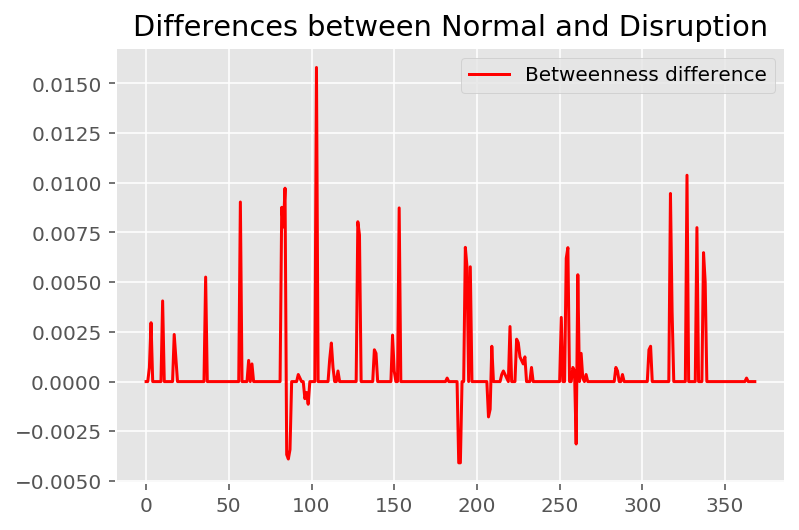

In [42]:
b_diff = np.array(list(nx.betweenness_centrality(G_overground).values())) - \
    np.array(list(nx.betweenness_centrality(G_dr_1_o).values()))
plt.plot(list(range(nx.number_of_nodes(G_overground))), b_diff, color='r')
plt.legend(['Betweenness difference'], prop={'size': 10})
plt.title('Differences between Normal and Disruption')
plt.show()